In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -U keras
!pip install -U torchtext==0.18.0
!pip install -U torch==2.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5

In [3]:
import os
import pandas as pd

In [4]:

# # Đường dẫn tới thư mục trong Google Drive để lưu các file
save_path = '/content/gdrive/MyDrive/Cookie_Classifier'
os.makedirs(save_path, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại

# # Đọc file CSV
file_path = '/content/gdrive/MyDrive/Cookie_Dataset_Test/cookies_data.csv'
df = pd.read_csv(file_path)

# Chỉ lấy n hàng đầu tiên
df = df.head(500000)

# # # Chia dataset thành 3 tập: 80:10:10
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

# Lưu 3 tập vào Google Drive
train_data.to_csv(os.path.join(save_path, 'train.csv'), index=False)
val_data.to_csv(os.path.join(save_path, 'valid.csv'), index=False)
test_data.to_csv(os.path.join(save_path, 'test.csv'), index=False)

print("Train, validation, and test datasets have been saved to:", save_path)

Train, validation, and test datasets have been saved to: /content/gdrive/MyDrive/Cookie_Classifier


In [5]:
def load_data_from_path(file_path):
    examples = []
    df = pd.read_csv(file_path)

    # Giữ lại các hàng có label thuộc {0, 1, 2, 3, 4}
    df = df[df['label'].isin({0, 1, 2, 3, 4})]

    for _, row in df.iterrows():
        text = row['value']
        label = row['label']
        data = {
            'sentence': text,
            'label': label
        }
        examples.append(data)

    return pd.DataFrame(examples)

In [6]:

file_paths = {
    'train': '/content/gdrive/MyDrive/Cookie_Classifier/train.csv',
    'valid': '/content/gdrive/MyDrive/Cookie_Classifier/valid.csv',
    'test': '/content/gdrive/MyDrive/Cookie_Classifier/test.csv'
}

train_df = load_data_from_path(file_paths['train'])
valid_df = load_data_from_path(file_paths['valid'])
test_df = load_data_from_path(file_paths['test'])

In [7]:
train_df

,sentence,label
0,-3,0
1,{stamp:%27lc7wchMP6csFKbu/swr86qKyRMPpZKvu9J/n...,0
2,{stamp:%27RyGbhHBKDtxlHbDhpfirX51dzG0VOa6+q9v0...,0
3,true,4
4,true,4
...,...,...
391013,kEuSY2Vj91w,3
391014,owhyeGr_hO4,3
391015,fMVD6tdaEsk,3
391016,ro-5KXbQjy8,3


In [8]:

def preprocess_text(text):
  if isinstance(text, str):
    text = text.lower()
  return text

In [9]:

train_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

In [10]:
train_df = train_df.dropna(subset=['preprocess_sentence'])
valid_df = valid_df.dropna(subset=['preprocess_sentence'])
test_df = test_df.dropna(subset=['preprocess_sentence'])

In [11]:
vocab_size = 100000

In [12]:
!pip install tensorflow

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def create_char_vocab(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]
    elif isinstance(sentences, pd.Series):
        sentences = sentences.dropna().astype(str).tolist()
    elif not isinstance(sentences, list):
        raise ValueError("Đầu vào phải là một chuỗi, danh sách, hoặc pandas.Series")

    all_chars = set(''.join(sentences))
    char_to_idx = {char: idx + 1 for idx, char in enumerate(all_chars)}
    char_to_idx['<PAD>'] = 0
    return char_to_idx
def char_encode(sentences, char_to_idx, maxlen=128):
    sequences = []
    for sentence in sentences:
        if not isinstance(sentence, str) or not sentence:
            sequences.append([0] * maxlen)
            continue
        seq = [char_to_idx.get(char, 0) for char in sentence]
        sequences.append(seq)

    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded_sequences

char_to_idx = create_char_vocab(train_df['preprocess_sentence'])
char_sequences = char_encode(train_df['preprocess_sentence'], char_to_idx, maxlen=128)

print(char_sequences.shape)
print(char_sequences[1])

(382938, 128)
[ 9 21 43 63 26 53 35  6 61 31 23 64 31 45 64 62 26 53 46 64 21  3 14 11
 55 18 21 45 58 56 46 25 14 16 58 26 53 53 57 14  5 55 34 12 18  7 10 64
 13 53 34 69 21 47 55  7 11 64 25  7  1 44 17 63 48 48  6 61 31  6 61 64
  7 69 64 69 21 21 63 58 16 35 43 58 55 69  6 61 64 53 58 69  3 69 58 69
  7 64 69 21 35 43 58 55 69  6 61 64 21 43 63 43 13 21 43 13 64 21 35 43
 58 55 69  6 61 64 26 63]


In [14]:
print(train_df['preprocess_sentence'].isna().sum())  # Đếm số giá trị NaN trong train_df
print(valid_df['preprocess_sentence'].isna().sum())  # Đếm số giá trị NaN trong valid_df
print(test_df['preprocess_sentence'].isna().sum())   # Đếm số giá trị NaN trong test_df

0
0
0


In [15]:
def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        # Convert to a list of individual characters
        encoded_sentence = [char_to_idx.get(char, 0) for char in sentence]
        label = row['label']
        yield encoded_sentence, label

In [16]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()


from torchtext.data.functional import to_map_style_dataset

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [17]:
def collate_batch(batch):
    # Tách câu và nhãn
    sentences, labels = list(zip(*batch))
    seq_length = 128  # Đặt chiều dài chuẩn cố định


    # Chuẩn hóa độ dài: padding hoặc truncate
    padded_sentences = []
    for sentence in sentences:
        if len(sentence) < seq_length:
            padded = sentence + [0] * (seq_length - len(sentence))  # pad với 0
        else:
            padded = sentence[:seq_length]  # cắt nếu dài hơn
        padded_sentences.append(padded)

    encoded_sentences = torch.tensor(padded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels


In [18]:
import torch

In [19]:
from torch.utils.data import WeightedRandomSampler
y_train = torch.tensor([label for _, label in train_dataset], dtype=torch.long)

class_counts = [(y_train == i).sum().item() for i in range(5)]
class_weights = [1.0 / count if count else 0.0 for count in class_counts] # Handle zero counts
sample_weights = [class_weights[label] for label in y_train]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [20]:
from torch.utils.data import DataLoader

batch_size = 1024

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_batch,
    sampler=sampler
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [21]:
next(iter(train_dataloader))

(tensor([[10, 63,  1,  ...,  0,  0,  0],
         [69, 59, 23,  ...,  0,  0,  0],
         [52, 64, 21,  ...,  0,  0,  0],
         ...,
         [ 1, 17, 56,  ..., 10,  1, 16],
         [ 6, 31, 11,  ..., 36, 69, 11],
         [10, 63,  1,  ...,  0,  0,  0]]),
 tensor([2, 0, 2,  ..., 1, 3, 2]))

In [22]:
encoded_sentences, labels = next(iter(train_dataloader))

In [23]:
encoded_sentences.shape

torch.Size([1024, 128])

In [24]:
labels.shape

torch.Size([1024])

In [25]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor).to(device) # This line is modified

        optimizer.zero_grad()

        predictions = model(inputs, device)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [26]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor).to(device) # This line is modified

            predictions = model(inputs, device)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [27]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [28]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [ ]:
from torch import nn
from torch.nn import functional as F

embedding_dim = 128
hidden_size = 50

class RNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, X_batch, device):
        X_batch = X_batch.to(device)
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(
            embeddings,
            torch.randn(1, len(X_batch), hidden_size).to(device)
        )
        output = self.linear(output[: , -1])
        return output

In [ ]:
model = RNNClassifier(num_classes=5)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNClassifier(num_classes=5)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

num_epochs = 30
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  374 batches | accuracy    0.229
| epoch   1 |   100/  374 batches | accuracy    0.226
| epoch   1 |   150/  374 batches | accuracy    0.228
| epoch   1 |   200/  374 batches | accuracy    0.229
| epoch   1 |   250/  374 batches | accuracy    0.225
| epoch   1 |   300/  374 batches | accuracy    0.227
| epoch   1 |   350/  374 batches | accuracy    0.224
-----------------------------------------------------------
| End of epoch   1 | Time: 11.36s | Train Accuracy    0.225 | Train Loss    1.632 | Valid Accuracy    0.275 | Valid Loss    1.571 
-----------------------------------------------------------
| epoch   2 |    50/  374 batches | accuracy    0.223
| epoch   2 |   100/  374 batches | accuracy    0.226
| epoch   2 |   150/  374 batches | accuracy    0.226
| epoch   2 |   200/  374 batches | accuracy    0.227
| epoch   2 |   250/  374 batches | accuracy    0.230
| epoch   2 |   300/  374 batches | accuracy    0.226
| epoch   2 |   350/  374 batches | accuracy   

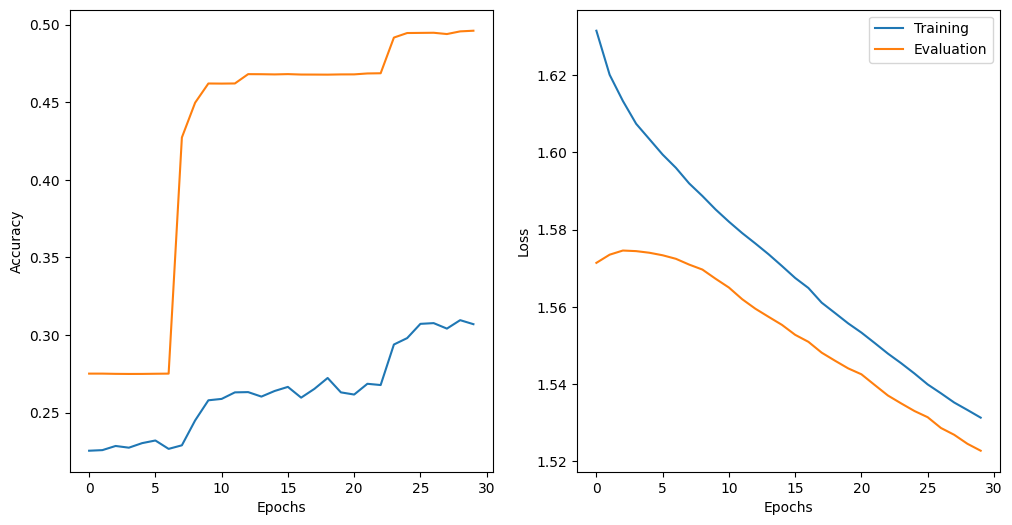

In [ ]:
  plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.4419408883924736, 1.5212196111679077)

In [ ]:
import torch
from torch import nn

embedding_dim = 128
hidden_size = 50

class LSTMClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )

        # Chỉ 1 lớp LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True
        )

        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.linear = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X_batch, device=None):  # device không cần nếu model đã .to(device)
        embeddings = self.embedding_layer(X_batch)                        # (batch_size, seq_len, embedding_dim)
        output, (hidden, cell) = self.lstm(embeddings)                   # output: (batch_size, seq_len, hidden_size)
        pooled = self.global_max_pooling(output.permute(0, 2, 1))        # (batch_size, hidden_size, 1)
        logits = self.linear(pooled.squeeze(-1))                         # (batch_size, num_classes)
        probs = self.softmax(logits)
        return probs


In [ ]:
model = LSTMClassifier(num_classes=5)

In [ ]:
predictions = model(encoded_sentences, device='cpu')

In [ ]:
predictions.shape

torch.Size([1024, 5])

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(num_classes=5)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 30
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

!nvidia-smi

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

Thu May  8 04:29:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |    1042MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

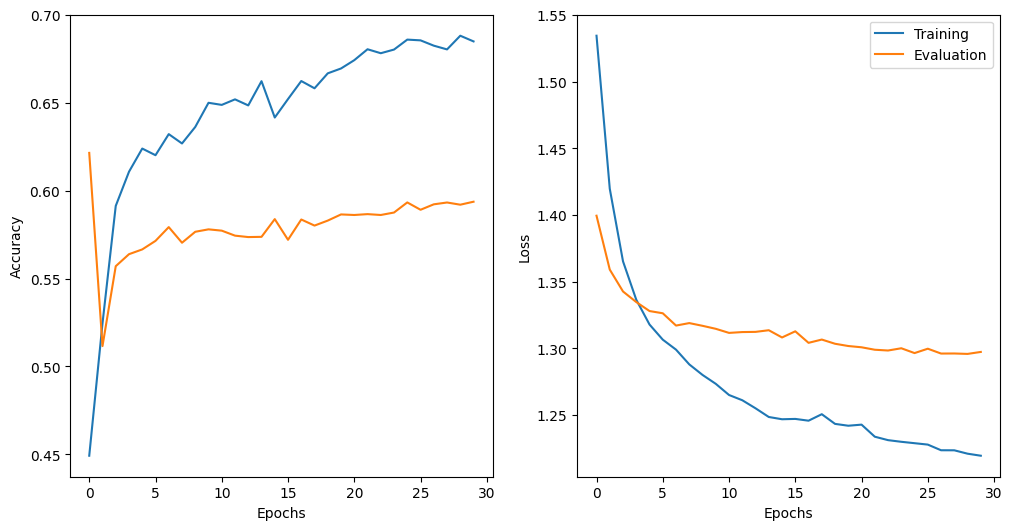

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.5953045794312226, 1.299468351447064)

In [29]:
import torch.nn as nn

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [31]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

In [32]:
embed_dim = 128
max_length = 128
embedding = TokenAndPositionEmbedding(
    vocab_size,
    embed_dim,
    max_length
)

In [33]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [34]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embd_layer = TokenAndPositionEmbedding(
            vocab_size, embed_dim, max_length, device
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=5)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x, device):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [35]:
max_length = 128
embed_dim = 128
num_heads = 4
ff_dim = 128
dropout=0.1
model = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout
)

In [36]:
encoded_sentences.shape

torch.Size([1024, 128])

In [37]:
predictions = model(encoded_sentences, device=device)

In [38]:
predictions.shape

torch.Size([1024, 5])

In [39]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
num_epochs = 30
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  374 batches | accuracy    0.277
| epoch   1 |   100/  374 batches | accuracy    0.325
| epoch   1 |   150/  374 batches | accuracy    0.376
| epoch   1 |   200/  374 batches | accuracy    0.440
| epoch   1 |   250/  374 batches | accuracy    0.465
| epoch   1 |   300/  374 batches | accuracy    0.480
| epoch   1 |   350/  374 batches | accuracy    0.513
-----------------------------------------------------------
| End of epoch   1 | Time: 41.06s | Train Accuracy    0.521 | Train Loss    1.382 | Valid Accuracy    0.521 | Valid Loss    1.147 
-----------------------------------------------------------
| epoch   2 |    50/  374 batches | accuracy    0.532
| epoch   2 |   100/  374 batches | accuracy    0.547
| epoch   2 |   150/  374 batches | accuracy    0.555
| epoch   2 |   200/  374 batches | accuracy    0.559
| epoch   2 |   250/  374 batches | accuracy    0.563
| epoch   2 |   300/  374 batches | accuracy    0.570
| epoch   2 |   350/  374 batches | accuracy   

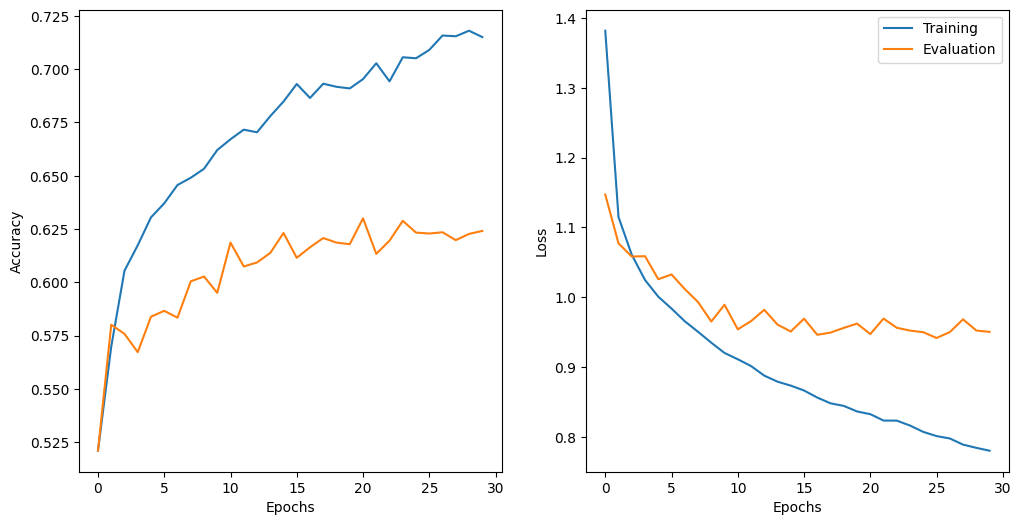

In [40]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [41]:

test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.6480582524271845, 0.946544846114905)